In [1]:
"""
Utility functions for plotting Bloch spheres on matplotlib ax.
Extracted and refactored from QuTiP's Bloch sphere implementation.
"""

import numpy as np
from numpy import linspace, cos, sin, ones, outer, pi, size
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

import torch
import qutip

sphere_color="#FFDDDD"
sphere_alpha = 0.2
frame_color = 'gray'
frame_alpha = 0.2
frame_width = 1

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

def show_label(ax, **opts):
    ax.scatter(-1,0,0, "$-1$", color="black")
    ax.scatter(1,0,0, "$1$", color="black")
    ax.scatter(0,-1,0, "$-1$", color="black")
    ax.scatter(0,1,0, "$1$", color="black")
    ax.scatter(0,0,-1, "$-1$", color="black")
    ax.scatter(0,0,1, "$1$", color="black")

    ax.text(-1.2, 0, 0, "$-x$", **opts)
    ax.text( 1.2, 0, 0,  "$x$", **opts)

    ax.text(0, -1.2, 0, "$-y$", **opts)
    ax.text(0,  1.2, 0,  "$y$", **opts)

    ax.text(0, 0, -1.2, "$-z$", **opts)
    ax.text(0, 0,  1.2,  "$z$", **opts)

def plot_back(ax):
    # back half of sphere
    u = linspace(0, pi, 25)
    v = linspace(0, pi, 25)
    x = outer(cos(u), sin(v))
    y = outer(sin(u), sin(v))
    z = outer(ones(size(u)), cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2,
                            color=sphere_color, linewidth=0,
                            alpha=sphere_alpha)
    # wireframe
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5,
                                color=frame_color,
                                alpha=frame_alpha)
    # equator
    ax.plot(1.0 * cos(u), 1.0 * sin(u), zs=0, zdir='z',
                    lw=frame_width, color=frame_color)
    ax.plot(1.0 * cos(u), 1.0 * sin(u), zs=0, zdir='x',
                    lw=frame_width, color=frame_color)

def plot_front(ax):
    # front half of sphere
    u = linspace(-pi, 0, 25)
    v = linspace(0, pi, 25)
    x = outer(cos(u), sin(v))
    y = outer(sin(u), sin(v))
    z = outer(ones(size(u)), cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2,
                            color=sphere_color, linewidth=0,
                            alpha=sphere_alpha)
    # wireframe
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5,
                                color=frame_color,
                                alpha=frame_alpha)
    # equator
    ax.plot(1.0 * cos(u), 1.0 * sin(u),
                    zs=0, zdir='z', lw=frame_width,
                    color=frame_color)
    ax.plot(1.0 * cos(u), 1.0 * sin(u),
                    zs=0, zdir='x', lw=frame_width,
                    color=frame_color)

## Euler_example.png

In [ ]:

X = np.array([
    [0,1],
    [1,0]
], dtype=np.complex128)

Y = np.array([
    [0, -1j],
    [1j, 0]
], dtype=np.complex128)
Z = np.array([
    [1, 0],
    [0, -1]
], dtype=np.complex128)


Dt = [1e-1, 1e-2, 1e-3]
dt = 1e-2

Exact_state = lambda t: np.array([np.cos(t), -1j * np.sin(t)], dtype=np.complex128).reshape(2,1)

Hamiltonian = X

t_list_1 = np.arange(0, np.pi*40, 1e-1, dtype=np.float64)
t_list_2 = np.arange(0, np.pi*40, 1e-2, dtype=np.float64)
t_list_3 = np.arange(0, np.pi*40, 1e-3, dtype=np.float64)
norm_dt = {
    "1": np.zeros_like(t_list_1, dtype=np.float64),
    "2": np.zeros_like(t_list_2, dtype=np.float64),
    "3": np.zeros_like(t_list_3, dtype=np.float64)
}
T_list = {
    "1": t_list_1,
    "2": t_list_2,
    "3": t_list_3,
}




for key, temp_t in T_list.items():
    initial_state = np.array([1,0], dtype=np.complex128).reshape(2,1)
    dt = np.diff(temp_t)[0]
    for i in range(len(temp_t)):
        expval = initial_state.conj().T @ initial_state
        norm_dt[key][i] = expval.real
        initial_state += -1j * dt *Hamiltonian @ initial_state



In [ ]:

X = np.array([
    [0,1],
    [1,0]
], dtype=np.complex128)

Y = np.array([
    [0, -1j],
    [1j, 0]
], dtype=np.complex128)
Z = np.array([
    [1, 0],
    [0, -1]
], dtype=np.complex128)

observable = {
    # "X": X,
    r"$\left<Y\right>$": Y,
    r"$\left<Z\right>$": Z,
    "norm": np.eye(2, dtype=np.complex128)
}
dt = 1e-2
t_list = np.arange(0, np.pi*20, dt, dtype=np.float64)

Exact_state = lambda t: np.array([np.cos(t), -1j * np.sin(t)], dtype=np.complex128).reshape(2,1)

Hamiltonian = X
obs_result = {
    key: np.zeros_like(t_list, dtype=np.float64) for key in observable.keys()
}
exact_result = {
    key: np.zeros_like(t_list, dtype=np.float64) for key in observable.keys()
}


initial_state = np.array([1,0], dtype=np.complex128).reshape(2,1)
for i in range(len(t_list)):
    for key, value in observable.items():
        expval = initial_state.conj().T @ value @ initial_state
        obs_result[key][i] = expval.real
        tmp = Exact_state(t_list[i])
        expval = tmp.conj().T @ value @ tmp
        exact_result[key][i] = expval.real
    initial_state += -1j * dt *Hamiltonian @ initial_state



In [ ]:
color_set = {
    r"$\left<Z\right>$": "#E95694",
    r"$\left<Y\right>$": "#6CB0D6",
    "norm": "#3a3a3a"
}
color_fig1 = ['#6E005F', '#AB1866', '#D12959']
fig, ax = plt.subplots(1,2, figsize=(10,4))

k=0
for key, temp_t in T_list.items():
    data = norm_dt.get(key)
    value = -1*int(key)
    ax[0].plot(temp_t, data, label=r"$dt=10^{" + str(value) + r"}$", color=color_fig1[k])
    k+=1
    # ax[0].set_yscale("log")
ax[0].set_ylim(0,10)
ax[0].grid(alpha=0.3)
ax[0].set_ylabel(r"$\left\langle \psi | \psi \right\rangle$")
ax[0].set_xlabel(r"$t$"+ " (A.U)")
ax[0].tick_params(axis="both", size=8, labelsize=10, width=1)
ax[0].legend()


lines = {
    key: [] for key in obs_result.keys()
}


for key, value in obs_result.items():
    l1,  = ax[1].plot(t_list, value, label=key, color=color_set.get(key), linestyle="dotted")
    l2,  = ax[1].plot(t_list, exact_result.get(key), label=key, color=color_set.get(key))
    lines.get(key).append(l1)
    lines.get(key).append(l2)


line = []; label = []
for key, value in lines.items():
    line.append(tuple(value))
    label.append(key)

ax[1].grid(alpha=0.3)
ax[1].set_ylim(-2, 2)

ax[1].set_xlabel(r"$t$"+ " (A.U)")


ax[1].legend(line, label, loc="lower right", handler_map={tuple: HandlerTuple(ndivide=None)})

ax[1].tick_params(axis="both", size=8, labelsize=10, width=1)
ax[1].set_yticks([-2, -1, 0, 1, 2])
fig.tight_layout()
fig.savefig("../Presentation/media/Euler_example.png")
plt.show()

## RK7 example

In [2]:
import sys
# ! TODO : modify path for your environment
sys.path.append("/Users/hun/circuit")

import qutrit
from qutrit import Bloch
Y = torch.tensor([
    [0, -1j],
    [1j, 0]
], dtype=torch.complex128)
Z = torch.tensor([
    [1, 0],
    [0, -1]
], dtype=torch.complex128)
H = torch.tensor([
    [0,1],
    [1,0]
], dtype=torch.complex128)
X = H

def f(t, psi):
    return -1j* H @ psi
observable = {
    r"$\left<Y\right>$": Y,
    r"$\left<Z\right>$": Z,
    "norm": torch.eye(2, dtype=torch.complex128)
}

initial_state = torch.zeros(2, dtype=torch.complex128)
initial_state[0] = 1
options = {
	'max_step': 2e-3,
	'event_tolerance': 1e-5,
	'base_step_size': 1e-2
}

In [ ]:
dt = 1e-2
t0 = torch.tensor(0, dtype=torch.float64)
integrator = qutrit.IntegratorVern7(f, observable=observable, options=options)
integrator.set_state(t0, initial_state)
tlist = torch.arange(t0.item(),torch.pi*20, dt, dtype=torch.float64)

In [ ]:
expvals = {
	key: torch.zeros_like(tlist, dtype=torch.float64) 
	for key in observable.keys()
}

# Store initial expectation values (t=0)
t, state, initial_expvals = integrator.get_state()
print(f"t: {t.item().real :.3f}µs")
for key, value in initial_expvals.items():
    print(f"{key}:\t{value:.4f}")
print("\n")

for key, value in initial_expvals.items():
    expvals[key][0] = value

# Evolution loop
for i, (t, state, current_expvals) in enumerate(integrator.run(tlist), start=1):
    # Store expectation values for this time step
    for key, value in current_expvals.items():
        expvals[key][i] = value

In [ ]:
color_set = {
    r"$\left<Z\right>$": "#E95694",
    r"$\left<Y\right>$": "#6CB0D6",
    "norm": "#3a3a3a"
}
fig, ax = plt.subplots(1,2, figsize=(10,4))

lines = {
    key: [] for key in expvals.keys()
}


for key, value in expvals.items():
    l1,  = ax[0].plot(tlist, value, label=key, color=color_set.get(key), linestyle="dotted")
    l2,  = ax[0].plot(t_list, exact_result.get(key), label=key, color=color_set.get(key))
    lines.get(key).append(l1)
    lines.get(key).append(l2)


line = []; label = []
for key, value in lines.items():
    line.append(tuple(value))
    label.append(key)

ax[0].grid(alpha=0.3)
ax[0].set_ylim(-2, 2)

ax[0].set_xlabel(r"$t$"+ " (A.U)")



ax[0].tick_params(axis="both", size=8, labelsize=10, width=1)
ax[0].set_yticks([-2, -1, 0, 1, 2])
ax[0].set_title(r"Run with 7th order RK($dt=10^{-2}$)")

ax[0].legend(line, label, loc="lower right", handler_map={tuple: HandlerTuple(ndivide=None)})

lines = {
    key: [] for key in obs_result.keys()
}


for key, value in obs_result.items():
    l1,  = ax[1].plot(t_list, value, label=key, color=color_set.get(key), linestyle="dotted")
    l2,  = ax[1].plot(t_list, exact_result.get(key), label=key, color=color_set.get(key))
    lines.get(key).append(l1)
    lines.get(key).append(l2)


line = []; label = []
for key, value in lines.items():
    line.append(tuple(value))
    label.append(key)

ax[1].grid(alpha=0.3)
ax[1].set_ylim(-2, 2)

ax[1].set_xlabel(r"$t$"+ " (A.U)")



ax[1].tick_params(axis="both", size=8, labelsize=10, width=1)
ax[1].set_yticks([-2, -1, 0, 1, 2])
ax[1].set_title(r"Run with Euler Method($dt=10^{-2}$)")

ax[1].legend(line, label, loc="lower right", handler_map={tuple: HandlerTuple(ndivide=None)})
fig.tight_layout()
fig.savefig("../Presentation/media/RK_comparison.png")
plt.show()

In [ ]:
!rm ./temp/* ./bloch.mp4

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), subplot_kw={"projection" : "3d"})

full_trajectory = torch.load("./asset/test_trajectory.pt").numpy() * 2

for i in range(int(full_trajectory.shape[0]/10)):
    ax.view_init(azim=30, elev=30)
    plot_back(ax)
    
    a = Arrow3D(xs=[0, 0], ys=[0, 0], zs=[0, 1.5], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)

    trajectory = full_trajectory[max(0, i*10 - 100):min(i*10, len(full_trajectory))]
    ax.scatter(trajectory[:,0], trajectory[:,1], trajectory[:,2], c=np.arange(len(trajectory)), cmap="rainbow", s=1)
      
    
    plot_front(ax)
    show_label(ax)
    ax.axis("off")
    ax.legend()
    fig.tight_layout(pad=0)
    fig.savefig(fname=f'./temp/bloch_{i}.png')  # saving images to temp directory in current working directory
    ax.clear()

plt.close(fig)

In [ ]:
!ffmpeg -i temp/bloch_%01d.png bloch.mp4

## CPMG

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import time
from contextlib import redirect_stdout

@dataclass
class NVsystem():
    num_C13: int = 3
    
    A_p: list = field(default_factory=lambda: [-0.130*2*np.pi, -0.210*2*np.pi, 0.045*2*np.pi])    # [MHz] - parallel coupling
    A_s: list = field(default_factory=lambda: [ 0.050*2*np.pi,  0.003*2*np.pi, 0.025*2*np.pi])    # [MHz] - perpendicular coupling
    
    gamma_c: float = 0.0010705 *2*np.pi     # [MHz/G]
    gamma_e: float = 2.8031 *2*np.pi     # [MHz/G]

    B_z: float = 440.1          # [G]
    N: int = 16                 # Number of pulses
    tau: float = 156.25        # [μs] # TODO : how to set tau?
    phi: float = 0.0            # Initial phase
    pi_pulse_duration: float= 0.025 # [μs] # sigma(0.05 /4/np.sqrt(np.pi)) * 6
#     pi_pulse_duration: float= 0.042314 # [μs] # sigma(0.05 /4/np.sqrt(np.pi)) * 6
    Omega_RF: float = 1e-4 * 2*np.pi      #[MHz]
    
    # Computed attributes
    omega_L: float = field(init=False)
    omega_RF: float = field(init=False)
    phi_tau: float = field(init=False)
    
    # Pre-computed operators
    _H0: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    _Ix_kron: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    _Iy_kron: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    _Sx_kron: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    #_Sz_proj: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    _pi_pulse_times: Optional[torch.Tensor] = field(default=None, init=False, repr=False)
    _pi_pulse_amp: Optional[float] = field(default=None, init=False, repr=False)
    
    def __post_init__(self):
        # Calculate derived parameters
        self.omega_L = self.gamma_c * self.B_z                                                                      # ω_0 in legacy code
        self.omega_RF = [np.sqrt((self.omega_L - self.A_p[i])**2 + self.A_s[i]**2) for i in range(self.num_C13)]    # ω_1 in legacy code
        self.phi_tau = [(self.omega_L - self.omega_RF[i]) * (self.tau + self.pi_pulse_duration*0.5) for i in range(self.num_C13)]
        self.total_evo_time = (self.tau * 4  + self.pi_pulse_duration * 2) * (self.N/2)
        
        # Define Pauli matrices
        self.S_x = torch.tensor([
                [0, 1, 0],
                [1, 0, 1],
                [0, 1, 0]
        ], dtype=torch.complex128) / np.sqrt(2) 
        self.S_y = torch.tensor([
                [0, -1j, 0],
                [1j, 0, -1j],
                [0, 1j, 0]
        ], dtype=torch.complex128) / np.sqrt(2)
        self.S_z = torch.tensor([
                [1, 0, 0],
                [0, 0, 0],
                [0, 0, -1]
        ], dtype=torch.complex128)
        self.I_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128) / 2
        self.I_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128) / 2
        self.I_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128) / 2
        
        self.eye_3 = torch.eye(3, dtype=torch.complex128)
        self.eye_2 = torch.eye(2, dtype=torch.complex128)
        
        self.Sx_plus = torch.tensor([
                [0, 1, 0],
                [1, 0, 0],
                [0, 0, 0]
        ], dtype=torch.complex128) / np.sqrt(2)
        self.Sy_plus = torch.tensor([
                [0,-1j, 0],
                [1j, 0, 0],
                [0, 0, 0]
        ], dtype=torch.complex128) / np.sqrt(2)
        self.Sx_minus = torch.tensor([
                [0, 0, 0],
                [0, 0, 1],
                [0, 1, 0]
        ], dtype=torch.complex128) / np.sqrt(2)
        self.Sy_minus = torch.tensor([
                [0, 0, 0],
                [0, 0, -1j],
                [0, 1j, 0]
        ], dtype=torch.complex128) / np.sqrt(2)


        # Pre-compute frequently used operators
        self._precompute_operators()

    def _precompute_operators(self):
        """Pre-compute operators that don't change with time."""
        # Base operators
        eye_list = [self.eye_2 for _ in range(self.num_C13)]
        
        # H0 terms
        #Iz_sum = sum(
        #    qutrit._kronecker_product([self.eye_3] + eye_list[:i] + [self.I_z] + eye_list[i+1:])
        #    for i in range(self.num_C13)
        #)
        self._H0 	= \
        self.omega_L * sum(
                qutrit._kronecker_product([self.eye_3] + eye_list[:i] + [self.I_z] + eye_list[i+1:])
                for i in range(self.num_C13)
        ) 
        
        for i in range(self.num_C13):
            self._H0 += self.A_p[i] * qutrit._kronecker_product([self.S_z] + eye_list[:i] + [self.I_z] + eye_list[i+1:]) + \
                        self.A_s[i] * qutrit._kronecker_product([self.S_z] + eye_list[:i] + [self.I_x] + eye_list[i+1:])
        
        # self._H0        = torch.zeros_like(self._H0, dtype=torch.complex128)

        # RF pulse operators
        self._Ix_kron = sum(
                qutrit._kronecker_product([self.eye_3] + eye_list[:i] + [self.I_x] + eye_list[i+1:])
                for i in range(self.num_C13)
        )
        
        self._Iy_kron = sum(
                qutrit._kronecker_product([self.eye_3] + eye_list[:i] + [self.I_y] + eye_list[i+1:])
                for i in range(self.num_C13)
        )
        
        # MW pulse operator
        self._Sx_minus_kron = qutrit._kronecker_product([self.Sx_minus] + eye_list)
        
        # Pi pulse parameters
        self._pi_pulse_times = torch.tensor(
                [self.tau + 2*i*self.tau + i*self.pi_pulse_duration for i in range(self.N)], 
                dtype=torch.float64
        )
        self._pi_pulse_amp = 3*np.sqrt(np.pi) / 0.997 / self.pi_pulse_duration   # [MHz]

    def pi_pulse(self, t):
        """Calculate pi pulse amplitude at time t."""
        # Q = (t.real+self.tau).div(2*self.tau, rounding_mode="floor")
        # r = torch.remainder(t.real+self.tau, 2*self.tau)
        # return self._pi_pulse_amp if (Q-1)*self.pi_pulse_duration < r < Q*self.pi_pulse_duration else 0
    
        """Calculate pi pulse amplitude at time t."""
        gaussian_sum = torch.exp(-(t - self._pi_pulse_times - self.pi_pulse_duration/2)**2 / (2 * (self.pi_pulse_duration/6)**2)).sum()


        return self._pi_pulse_amp * gaussian_sum
    
    def adaptive_phase(self, t):
        """Calculate RF pulse phase at time t."""		
        # Determine which pulse period we're in
        idx = int((t + self.tau + self.pi_pulse_duration *0.5) / (2 * self.tau + self.pi_pulse_duration)) + 1
        phase = [self.phi + (idx - 1) * self.phi_tau[i] + (np.pi if idx % 2 == 0 else 0) for i in range(self.num_C13)]
        
                
        return torch.tensor(phase, dtype=torch.float64)
    
    def time_evo(self, t, y):
        """
        Time evolution of the system under Schrödinger equation.
        dy/dt = -i H(t) y
        
        Args:
                t: Current time
                y: State vector
                
        Returns:
                Time derivative of state vector
        """
        # Convert time to tensor if needed
        #if not isinstance(t, torch.Tensor):
        #		t = torch.tensor(t, dtype=torch.float32)
        
        H = self.Hamiltonian(t)

        # Schrödinger equation: dy/dt = -i H y
        return -1j * H @ y

    def Hamiltonian(self, t):
        """
        Time evolution of the system under Schrödinger equation.
        dy/dt = -i H(t) y
        
        Args:
                t: Current time
                y: State vector

        Returns:
                Time derivative of state vector
        """
        # Convert time to tensor if needed
        #if not isinstance(t, torch.Tensor):
        #		t = torch.tensor(t, dtype=torch.float32)
        
        # Start with pre-computed H0
        H = self._H0.clone()

        # MW pi pulse
        
        
        # RF pulse
        # Hard coded
        pi_amp = self.pi_pulse(t)
        if pi_amp.real < 2.3699:
                phi_rf = self.adaptive_phase(t)
                H_RF = 2 * self.Omega_RF * sum(
                [torch.cos(self.omega_RF[i] * t + phi_rf[i]) for i in range(self.num_C13)]
                ) * self._Ix_kron
                
                H += H_RF
        else:
                H += pi_amp * self._Sx_minus_kron
            

        # Schrödinger equation: dy/dt = -i H y
        return H
    
    def get_info(self):
        """Print system parameters."""
        print(f"NV System Parameters:")
        print(f"  Number of C13: {self.num_C13}")
        # print(f"  A_parallel: {self.A_p:.3f} kHz")
        # print(f"  A_perp: {self.A_s:.3f} kHz")
        print(f"  Larmor frequency: {self.omega_L:.3f} MHz")
        # print(f"  RF frequency: {self.omega_RF:.3f} kHz")
        # print(f"  Phase accumulation per tau: {self.phi_tau % (2*np.pi):.3f} rad")
        print(f"  pi pulse amplitude: {self._pi_pulse_amp:.3f} MHz")
        print(f"  RF Rabi frequency: {self.Omega_RF:.4f} MHz")
        print(f"  Number of pulses: {self.N}")
        print(f"  Pulse spacing: {self.tau:.3f} µs")
        print(f"  Total evo time: {self.total_evo_time:.3f} µs")
        print(f"  resonance tau: [ { ", ".join(["{:.4f}".format(torch.pi / (2*self.omega_L - self.A_p[i])) for i in range(self.num_C13)]) } ] µs")

In [4]:
dt=5e-1
test_system = NVsystem(tau=0.4663*6, N=20, Omega_RF=0, pi_pulse_duration=0.001, num_C13=1)
test_system.get_info()
evo_time = test_system.total_evo_time

NV System Parameters:
  Number of C13: 1
  Larmor frequency: 2.960 MHz
  pi pulse amplitude: 5333.362 MHz
  RF Rabi frequency: 0.0000 MHz
  Number of pulses: 20
  Pulse spacing: 2.798 µs
  Total evo time: 111.932 µs
  resonance tau: [ 0.4663 ] µs


In [5]:
H0 = test_system.omega_L * test_system.I_z
H1 = test_system.omega_L - test_system.A_p[0] * test_system.I_z - test_system.A_s[0] * test_system.I_x

H0 = H0.numpy()
H1 = H1.numpy()

sigma_x = test_system.I_x.numpy()
sigma_y = test_system.I_y.numpy()
sigma_z = test_system.I_z.numpy()

sigma = np.stack([sigma_x, sigma_y, sigma_z])

In [6]:
np.trace(sigma[0] @ sigma[0])

np.complex128(0.5+0j)

In [7]:
import scipy
Tau = np.arange(0.1, 20, 2e-2)
inner_prods = np.zeros_like(Tau)
vec_list_0 = np.zeros((3, len(Tau)))
vec_list_1 = np.zeros((3, len(Tau)))
for i in range(len(Tau)):
    tau = Tau[i]
    U0 = scipy.linalg.expm(-1j*H0*tau) @ scipy.linalg.expm(-1j*H1*2*tau) @ scipy.linalg.expm(-1j * H0 *tau)
    U1 = scipy.linalg.expm(-1j*H1*tau) @ scipy.linalg.expm(-1j*H0*2*tau) @ scipy.linalg.expm(-1j * H1 *tau)

    phi0 = np.arccos(np.trace(U0)/2)
    phi1 = np.arccos(np.trace(U1)/2)

    sigma0 = 1j / phi0 * scipy.linalg.logm(U0)
    sigma1 = 1j / phi1 * scipy.linalg.logm(U1)

    vec_sigma0 = np.einsum("ijk,kj", sigma, sigma0).real * 2
    vec_sigma1 = np.einsum("ijk,kj", sigma, sigma1).real * 2

    mag0 = np.linalg.norm(vec_sigma0)
    mag1 = np.linalg.norm(vec_sigma1)

    inner_prod = (vec_sigma1 * vec_sigma0).sum() / mag0/mag1
    inner_prods[i] = inner_prod
    vec_list_0[:, i] = vec_sigma0/mag0
    vec_list_1[:, i] = vec_sigma1/mag1

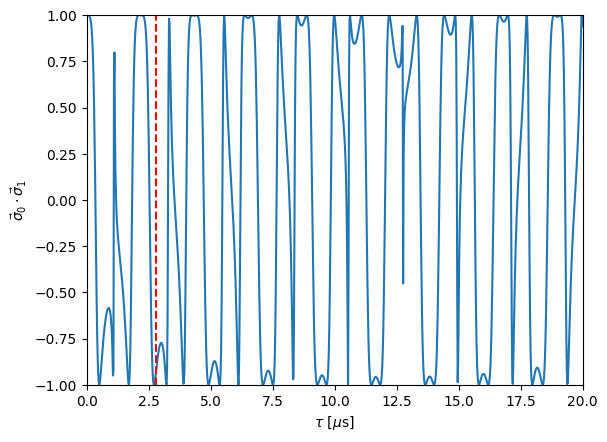

In [8]:
fig, ax = plt.subplots(1)
ax.plot(Tau, inner_prods)
ax.set_ylim(-1,1)
ax.set_ylabel(r"$\vec{\sigma}_{0}\cdot\vec{\sigma}_{1}$")
ax.set_xlim(0, 20)
ax.set_xlabel(r"$\tau$ [$\mu$s]")
ax.vlines(0.4663*6, ymin=-1, ymax=1, color="red", linestyle="--")



In [22]:
for i in range(len(Tau)):
    # Set up a figure twice as tall as it is wide
    fig = plt.figure(figsize=(10, 5), facecolor="#ffffff")
    fig.suptitle(rf'CPMG at $\tau = {tau:.2f}$')

    tau = Tau[i]

    # First subplot
    ax = fig.add_subplot(1, 2, 1)
    ax.set_facecolor("#ffffff")

    ax.plot(Tau, inner_prods)
    ax.set_ylim(-1,1)
    ax.set_ylabel(r"$\vec{\sigma}_{0}\cdot\vec{\sigma}_{1}$")
    ax.set_xlim(0, 20)
    ax.set_xlabel(r"$\tau$ [$\mu$s]")
    ax.vlines(tau, ymin=-1, ymax=1, color="orange", linestyle="--")
    ax.vlines(0.4663*6, ymin=-1, ymax=1, color="red", linestyle="--", label=r"$\tau$ = "+f"{0.4663*6}")
    ax.grid(alpha=0.3)
    ax.legend(loc="upper right")

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_facecolor("#ffffff")

    ax.view_init(azim=30, elev=30)
    plot_back(ax)

    a = Arrow3D(xs=[0, 1.1*vec_list_0[0, i]], ys=[0, 1.1*vec_list_0[1, i]], zs=[0, 1.1*vec_list_0[2, i]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    b = Arrow3D(xs=[0, 1.1*vec_list_1[0, i]], ys=[0, 1.1*vec_list_1[1, i]], zs=[0, 1.1*vec_list_1[2, i]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="b")
    ax.add_artist(a)
    ax.add_artist(b)

    plot_front(ax)
    show_label(ax)
    ax.axis("off")
    
    fig.tight_layout(pad=1)
    fig.savefig(f"./temp/CPMG_{i}.png")
    ax.clear()
    plt.close()

plt.show()

In [23]:
!ffmpeg -i temp/CPMG_%01d.png CPMG.gif -loop 0 -crf 0 -y

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e